In [1]:
import os, sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import gym

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/DQN/')
from agent import  Agent
sys.path.append('/Users/kanoumotoharu/Desktop/machine_learning/強化学習/実験コード/RL_algorithms/Memory/')
from PrioritizedExperienceMemory import ProportionalReplayMemory

In [3]:
class Environment:
    def get_state(self, env, _obs):
        env_low = env.observation_space.low 
        env_high = env.observation_space.high 
        # normalize
        state = (_obs - env_low)/(env_high - env_low)
        return state.tolist()

    def get_reward(self, env, _obs, reward):
        reward = float(_obs[0])
        #reward = float(reward)
        #env_low = env.observation_space.low 
        #env_high = env.observation_space.high 
        # normalize
        #state = (_obs - env_low)/(env_high - env_low)
        return reward
    def get_action(self,env, action):
        action = int(action)

        return action

    def get_data(self, env, obs, next_obs, reward, action):
        state = self.get_state(env, obs)
        next_state = self.get_state(env, next_obs)
        low = env.observation_space.low[0]
        high = env.observation_space.high[0]
        reward = float((next_obs[0]-low)/(high-low))
        reward = 2*reward-1
        
        if next_obs[0]>=env.observation_space.high[0]-0.1:
            reward*=2
        if next_obs[0]>=env.observation_space.high[0]-0.001:
            reward*=5
        #reward = self.get_reward(env, reward)
        action = self.get_action(env, action)

        return state, action, next_state, reward

In [4]:
#make env
env = gym.make('MountainCar-v0')

In [5]:
action_space = env.action_space.n
environment = Environment()
replay_memory = ProportionalReplayMemory(10000)
agent = Agent(action_space=action_space )

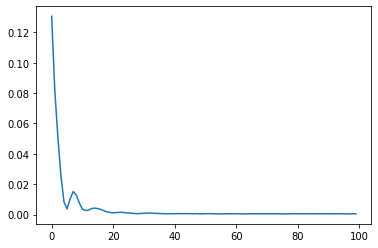

In [6]:
# 楽観的初期化
loss_list = agent.init_param_optim(100, env, environment)
plt.plot(loss_list)

In [7]:
actions = []
rewards = []
loss = []

In [8]:
# 10000エピソードで学習する
for episode in range(10):
    total_reward = 0
    observation = env.reset()
    for _ in range(1000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor(now_state)
        action =  agent.get_action(now_state)
        actions.append(action)
        
        #環境を取得
        next_observation, reward, done, _ = env.step(action)
        total_reward += reward
        
        #optim parameters
        state, action, next_state, reward = environment.get_data(env, observation, next_observation, reward, action)
        replay_memory.push(state, action, next_state, reward)
        _loss = agent.update_agent(replay_memory)
        
        if _loss is not None:
            loss.append(_loss)
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            rewards.append(total_reward)
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break

In [11]:
env.close()

In [12]:
#agent.policy_net.state_dict()

In [9]:
loss_df = pd.DataFrame(loss, columns=['loss'])
reward_df = pd.DataFrame(rewards, columns=['reward'])
action_df = pd.DataFrame(actions, columns=['action'])

loss_df['loss_r30'] = loss_df['loss'].rolling(30,min_periods=1).mean()
reward_df['reward_r30'] = reward_df['reward'].rolling(30,min_periods=1).mean()
action_df['action'] = action_df['action'].map({0:"push left", 1:"no push", 2:"push right"})

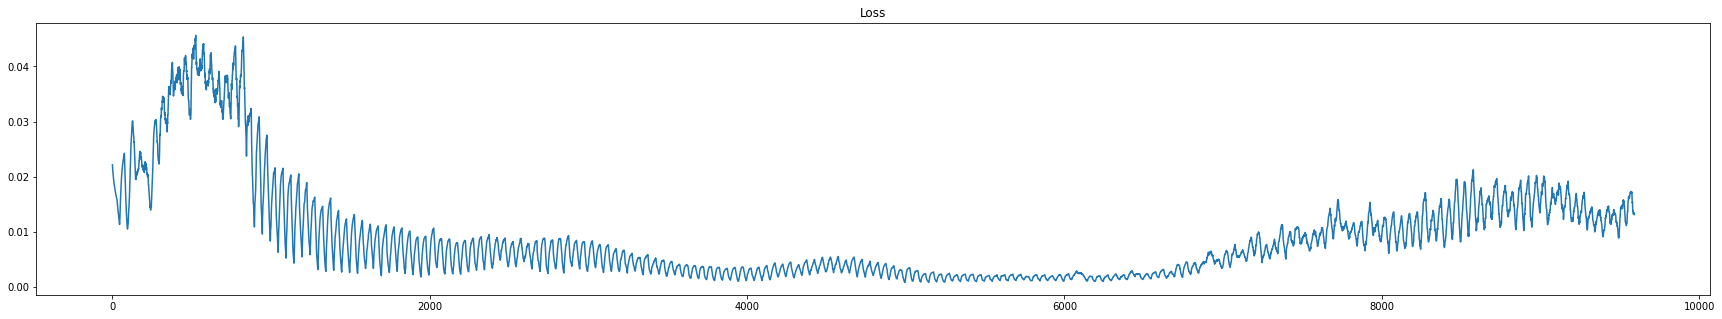

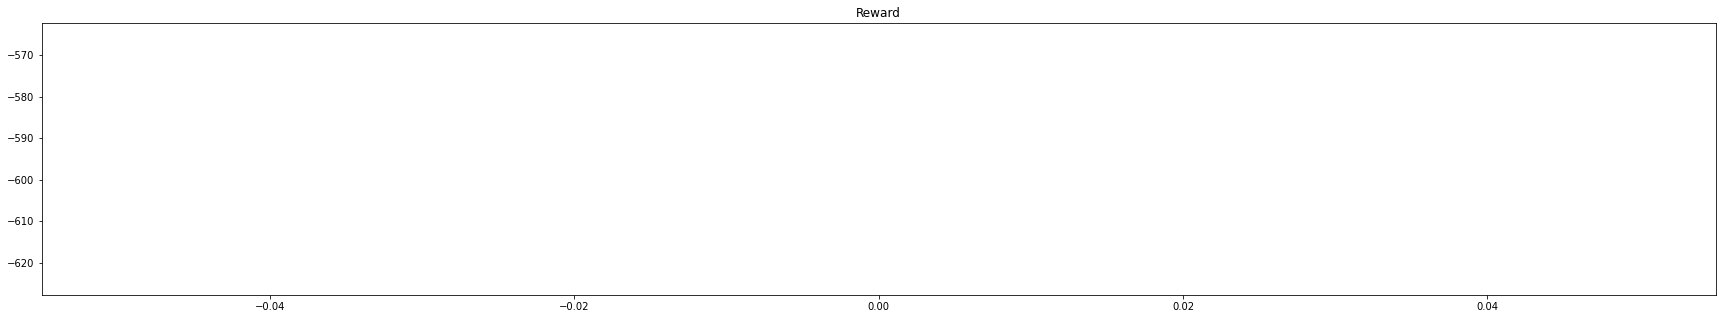

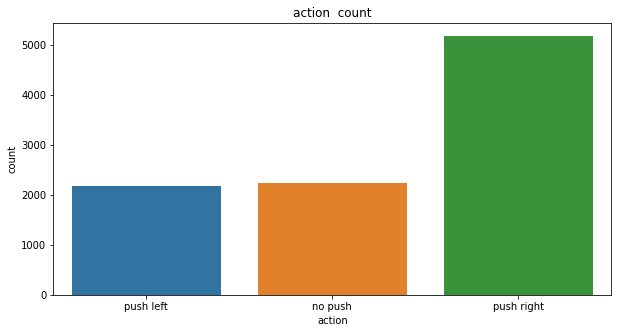

In [10]:
plt.figure(figsize=(30,5))
plt.plot(loss_df['loss_r30'])
plt.title('Loss')
plt.show()

plt.figure(figsize=(30,5))
plt.plot(reward_df['reward_r30'])
plt.title('Reward')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(action_df["action"], order=["push left", "no push","push right"])
plt.title("action  count")
plt.show()

In [12]:
# 10000エピソードで学習する
for episode in range(10):
    total_reward = 0
    observation = env.reset()
    for _ in range(1000):
        env.render()
        
        # ε-グリーディ法で行動を選択        
        now_state = environment.get_state(env, observation)
        now_state = torch.FloatTensor(now_state)
        action =  agent.get_action(now_state)

        next_observation, reward, done, _ = env.step(action)
        total_reward += reward
        observation = next_observation
        if observation[0]>=env.observation_space.high[0]-0.001:
            rewards.append(total_reward)
            # doneがTrueになったら１エピソード終了
            if episode%100 == 0:
                if episode==0:
                    mean_total_reward = total_reward
                else:
                    m = episode//100
                    mean_total_reward = np.mean(rewards[(m-1)*100:m*100])
                print(f'episode: {episode}, total_reward　mean: {mean_total_reward}')
            break

episode: 0, total_reward　mean: -729.0


KeyboardInterrupt: 